# Assignment: Network Measurements and Analysis of the Tor Network Using Open Data

## Objective
The assignment aims to explore Tor network measurements using publicly available datasets and metrics, focusing on understanding usage patterns, performance, censorship effects, and the impact of pluggable transports.

## Assignment Workflow
1. **Background Research and Familiarization**
   - Study the Tor network architecture, including relays, entry guards, exit nodes, and pluggable transports.
   - Understand the privacy and ethical considerations when measuring Tor data, referencing guidelines from Tor research literature [5], [8].
   - Review available open data sources such as Tor Metrics, CollecTor archives, and datasets like GTT23 [1], [4], [6], [7].

2. **Data Collection (5 points)**
   - Access Tor Metrics website and download relevant datasets (e.g., relay statistics, user counts by country, exit traffic by port) [1], [6].
   - Obtain the GTT23 dataset for genuine Tor traffic traces if advanced circuit-level analysis is planned [4], [7].
   - Explore additional tools like OnionPerf and Torperf for performance measurements [2], [3].

3. **Data Processing and Privacy Preservation (6 points)**
   - Use provided libraries such as Stem, the official Tor Project Python library for parsing Tor descriptors, consensuses, and controlling a Tor process [6].
   - Ensure no sensitive user data is exposed; work with aggregated or anonymized statistics.
   - Follow recommended practices to avoid possible deanonymization risks [5], [8].

4. **Interpretation and Reporting (9 points)**
   - Discuss findings in relation to Tor’s goals of anonymity and censorship resistance.
   - Reflect on limitations due to data aggregation and privacy constraints.
   - Suggest improvements or further research directions based on results.

## Potential Research Questions
- How does the usage of pluggable transports vary across different countries and time periods? Are there correlations with censorship events?
- Can sudden drops in Tor connections be linked to known political upheavals or Internet disruptions in specific regions?
- What are the predominant exit ports used in the Tor network, and what does this imply about user behavior and application usage?
- How does the performance of Tor (measured by OnionPerf or Torperf) fluctuate during periods of increased censorship or network interference?

## Research Question
We will examine Tor exit traffic usage and network performance, comparing global trends to Germany. Specifically, we ask: How does the distribution of exit traffic (by destination port) and download performance (via TorPerf/OnionPerf) differ globally versus for Germany? For example, we can analyze the most-used exit ports (e.g. 80, 443, etc.) and see if German users rely on different services. We will then correlate these usage patterns with Tor performance metrics (download times, latencies) to see if usage changes coincide with measurable performance differences. By contrasting Germany to the global average, we can highlight regional variations in Tor usage and quality of service.

## Data Sources and Tools
We will use open Tor data wherever possible:

- **Tor Metrics Portal**: Provides historical aggregates of users (by country), relay counts, bandwidth, exit traffic, and performance. Nearly all graphs have downloadable CSV data.
- **CollecTor Archives**: Tor’s CollecTor service archives raw data such as TorPerf/OnionPerf results and network descriptors. 
- **Stem library**: The Python Stem library can parse Tor consensus and descriptor archives.
- **GTT23 Dataset (optional)**: A recent dataset of “genuine Tor traces” collected at exit relays.

All sources of data are aggregated or permissioned to ensure privacy. We will work with country-level and time-series statistics only, avoiding any raw IP-level data. Tools like Pandas and requests in Python will automate data download and processing.

## 1. Setup and Dependencies

In [1]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr, spearmanr
import tarfile, lzma, json
from io import BytesIO, StringIO
from datetime import datetime
from dateutil.relativedelta import relativedelta
from stem.descriptor import parse_file, DocumentHandler
#from geoip import geolite2
import geoip2.database
from collections import defaultdict
from tqdm import tqdm
import shutil
import tempfile

# Set plot style
sns.set_theme(style="whitegrid")

## 2. Data Collection
Here we collect all the necessary data from the different sources.

In [2]:
# 1. Download Tor user counts (relay users) for all countries and Germany
print("1. Downloading Tor user counts...")
url_all = "https://metrics.torproject.org/userstats-relay-country.csv?country=all&start=2023-01-01&end=2023-12-31"
url_de  = "https://metrics.torproject.org/userstats-relay-country.csv?country=de&start=2023-01-01&end=2023-12-31"
df_global = pd.read_csv(url_all, comment='#')
df_germany = pd.read_csv(url_de, comment='#')
print("Global user stats:")
print(df_global.head())
print("German user stats:")
print(df_germany.head())

# 2. Download TorPerf performance data (public server, 50 KiB file)
print("2. Downloading TorPerf data...")
url_perf = "https://metrics.torproject.org/torperf.csv?filesize=50kb&server=public&start=2023-01-01&end=2023-12-31"
df_perf = pd.read_csv(url_perf, comment='#')
print(df_perf.head())

# 3. Fetch a sample Onionoo archive from CollecTor
print("3. Fetching Onionoo data for German exit relays...")
onnx_url = "https://onionoo.torproject.org/summary?flag=Exit&country=DE"
resp = requests.get(onnx_url)
exits_de = resp.json()['relays']
df_exits_de = pd.DataFrame(exits_de)
print(f"Found {len(df_exits_de)} exit relays in Germany.")
print(df_exits_de.head())

# 4. Get the Data out of README.csv for the Timeline metric
print("4. Processing Metrics Timeline...")
df_timeline = pd.read_csv("README.csv")
print(df_timeline.head())


1. Downloading Tor user counts...
Global user stats:
         date  country    users  lower  upper  frac
0  2023-01-01      NaN  2156347    NaN    NaN    77
1  2023-01-02      NaN  2352735    NaN    NaN    51
2  2023-01-07      NaN  2297430    NaN    NaN    75
3  2023-01-08      NaN  2329057    NaN    NaN    75
4  2023-01-09      NaN  2464609    NaN    NaN    52
German user stats:
         date country   users     lower     upper  frac
0  2023-01-01      de  270842  184755.0  416006.0    77
1  2023-01-02      de  290858  206240.0  385598.0    51
2  2023-01-07      de  301504  183730.0  400192.0    75
3  2023-01-08      de  309498  168017.0  428397.0    75
4  2023-01-09      de  307327  194435.0  427089.0    52
2. Downloading TorPerf data...
         date  filesize   source  server     q1    md     q3
0  2023-01-01     51200  op-de6a  public  0.330  0.71  1.070
1  2023-01-01     51200  op-de7a  public  0.417  0.77  1.095
2  2023-01-01     51200   op-hk6  public  1.632  1.81  2.197
3  20

## 3 Data Analysis and Visualization

### 3.1 Overall Data (Global Vs. Germany)

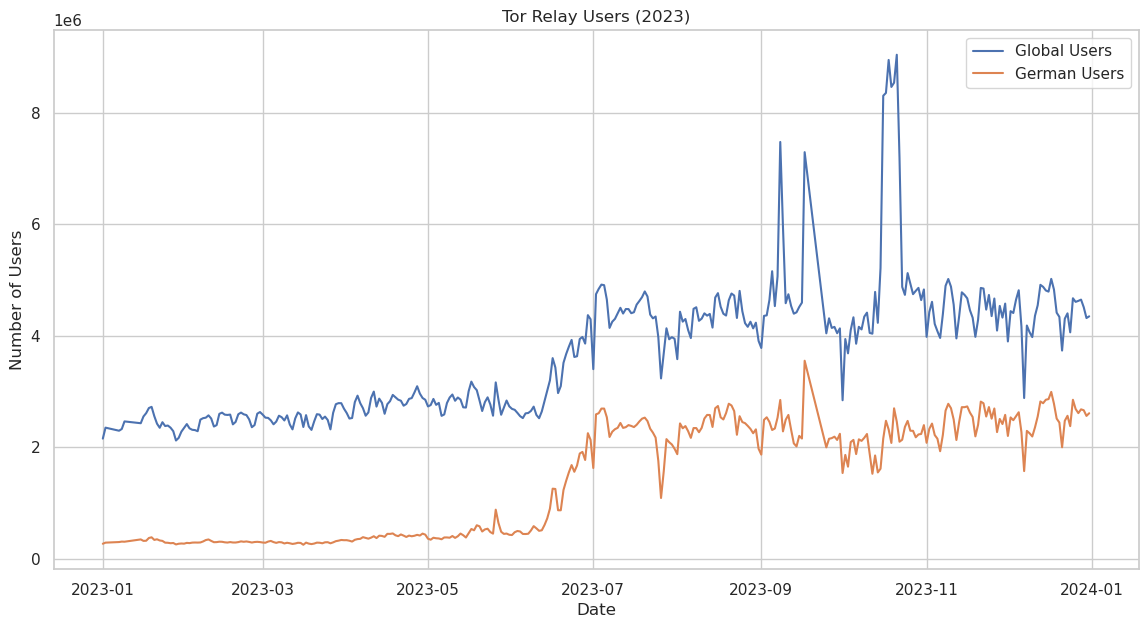

In [3]:
# Convert date columns to datetime objects
df_global['date'] = pd.to_datetime(df_global['date'])
df_germany['date'] = pd.to_datetime(df_germany['date'])
df_perf['date'] = pd.to_datetime(df_perf['date'])

# Plotting user counts
plt.figure(figsize=(14, 7))
plt.plot(df_global['date'], df_global['users'], label='Global Users')
plt.plot(df_germany['date'], df_germany['users'], label='German Users')
plt.title('Tor Relay Users (2023)')
plt.xlabel('Date')
plt.ylabel('Number of Users')
plt.legend()
plt.show()

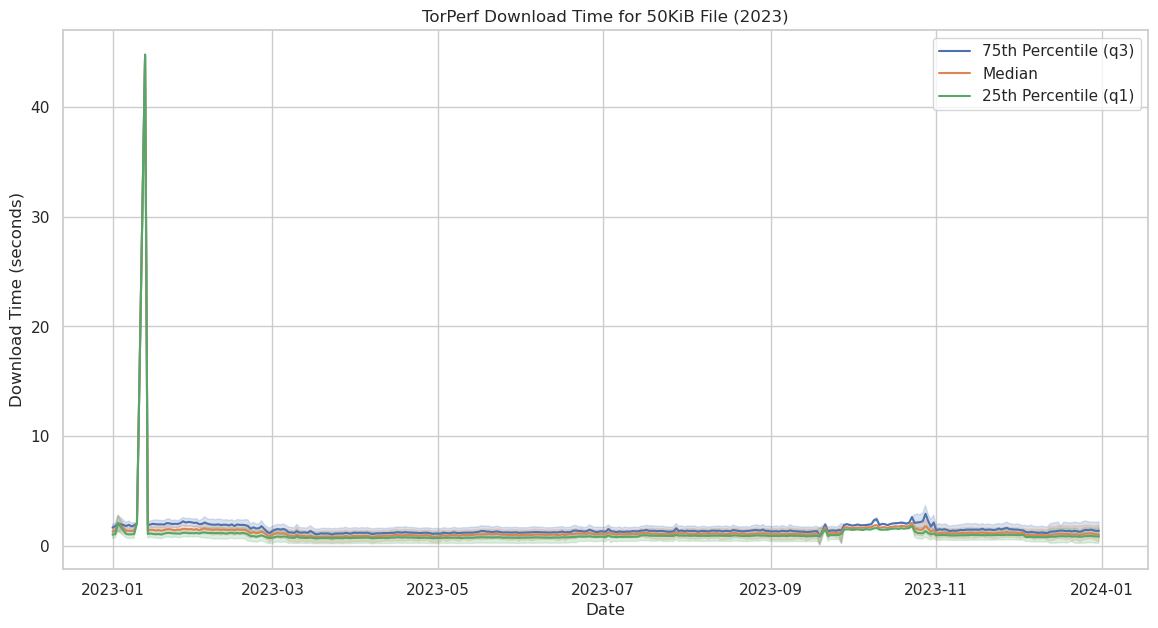

In [4]:
# Plotting TorPerf Data
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_perf, x='date', y='q3', label='75th Percentile (q3)')
sns.lineplot(data=df_perf, x='date', y='md', label='Median')
sns.lineplot(data=df_perf, x='date', y='q1', label='25th Percentile (q1)')
plt.title('TorPerf Download Time for 50KiB File (2023)')
plt.xlabel('Date')
plt.ylabel('Download Time (seconds)')
plt.legend()
plt.show()

In [5]:
# --- 3) Function: Filter events by significant change ---
def filter_events_by_change(df, events, window_days=7, pct_threshold=0.10):
    """
    Keep only those events where the relative difference
    in user counts `window_days` before/after the event
    is at least `pct_threshold`.
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing 'date' and 'users' columns.
    events : pandas.DataFrame
        DataFrame containing 'start_date' column of events.
    window_days : int, optional
        Time window (± days) to look before/after each event.
    pct_threshold : float, optional
        Minimum relative change threshold (e.g. 0.10 = 10%).

    Returns
    -------
    pandas.DataFrame
        Subset of `events` with only those rows that meet the threshold.
    """
    # Index by date and ensure chronological order
    df = df.set_index('date').sort_index()

    relevant = []
    for _, ev in events.iterrows():
        event_date = ev['start_date']
        # use asof to get the closest value before/after the window
        prev_val = df['users'].asof(event_date - pd.Timedelta(days=window_days))
        next_val = df['users'].asof(event_date + pd.Timedelta(days=window_days))

        # skip if either value is missing
        if pd.isna(prev_val) or pd.isna(next_val):
            continue

        # compute absolute relative change
        rel_change = abs(next_val - prev_val) / prev_val
        if rel_change >= pct_threshold:
            relevant.append(ev)

    return pd.DataFrame(relevant)


303 German exit relays (total: 2756 )
Port 443 policy: DE = 160 vs Global = 1984
Significant events (global): ['Upgraded tor from 0.4.7.13 to 0.4.8.6 on the snowflake-02 bridge. As the result of an apparent bug, the bridge starts reporting a number of OR protocol users about equal to the number of Snowflake users.', 'Restarted snowflake-server on the snowflake-02 bridge with `num-turbotunnel=8`.', 'Restarted snowflake-server on the snowflake-01 bridge with `num-turbotunnel=8`.', 'Restarted snowflake-server on the snowflake-01 bridge with `num-turbotunnel=1`.', 'Restarted snowflake-01 bridge after testing performance optimizations.', 'Restarted snowflake-01 bridge to test an optimization.', 'Restarted snowflake-01 bridge to test an optimization.', 'Restarted snowflake-01 bridge to test an optimization.', 'Restarted snowflake-01 bridge for a profiling change.', 'Restarted snowflake-server on the snowflake-01 bridge with `num-turbotunnel=4`.']
Significant events (DE):     ['Restarted the 

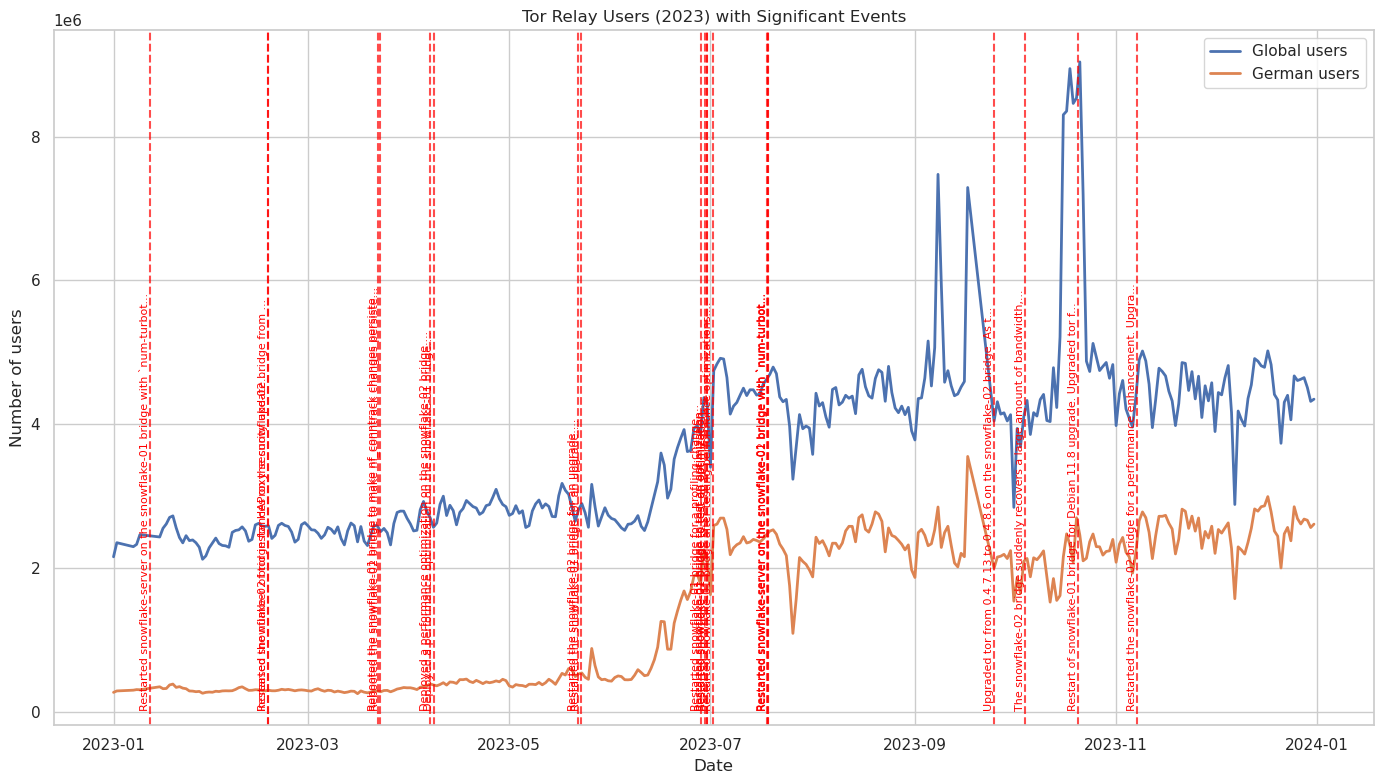

In [6]:
# 1) Load and filter events
events = pd.read_csv('README.csv', parse_dates=['start_date', 'end_date'])
# Ensure start_date is real datetime
events['start_date'] = pd.to_datetime(events['start_date'], errors='coerce')
# Keep only events in 2023
events = events[(events['start_date'] >= '2023-01-01') &
                (events['start_date'] <= '2023-12-31')].copy()


# 2) Onionoo: fetch all exit relays
url = (
    "https://onionoo.torproject.org/details?"
    "type=relay&flag=Exit&fields=country,exit_policy_summary"
)
data = requests.get(url).json()['relays']
# Filter German exit relays
relays_de = [r for r in data if r.get('country') == 'de']
print(len(relays_de), "German exit relays (total:", len(data), ")")

# 3) Example: count relays allowing port 443
count_443_de = sum(
    any(prange.startswith('443') for prange in r.get('exit_policy_summary', {}).get('accept', []))
    for r in relays_de
)
count_443_global = sum(
    any(prange.startswith('443') for prange in r.get('exit_policy_summary', {}).get('accept', []))
    for r in data
)
print("Port 443 policy: DE =", count_443_de, "vs Global =", count_443_global)

# --- 4) Identify significant events for global & DE user counts ---
df_global['date']  = pd.to_datetime(df_global['date'])
df_germany['date'] = pd.to_datetime(df_germany['date'])

events_global = filter_events_by_change(
    df_global, events,
    window_days=7, pct_threshold=0.10
)
events_de = filter_events_by_change(
    df_germany, events,
    window_days=7, pct_threshold=0.10
)

print("Significant events (global):", events_global['description'].tolist())
print("Significant events (DE):    ", events_de['description'].tolist())

# --- 5) Plot: Tor relay users with annotated significant events ---
plt.figure(figsize=(14, 8))
plt.plot(df_global['date'], df_global['users'],
         label='Global users', linewidth=2)
plt.plot(df_germany['date'], df_germany['users'],
         label='German users', linewidth=2)

ymin, ymax = plt.ylim()
for _, ev in pd.concat([events_global, events_de]).drop_duplicates().iterrows():
    d = ev['start_date']
    plt.axvline(d, color='red', linestyle='--', alpha=0.7)
    plt.text(d, ymin + (ymax - ymin) * 0.02,
             ev['description'][:70] + '...',
             rotation=90, va='bottom', ha='right',
             color='red', fontsize=8)

plt.title('Tor Relay Users (2023) with Significant Events')
plt.xlabel('Date')
plt.ylabel('Number of users')
plt.legend()
plt.tight_layout()
plt.show()


### 3.2 Allow Rate for Ports in different Countries & TorPerf with events

country   ALL    DE    FR    JP    RU    US
port                                       
443      72.0  52.8  90.1  85.7  95.1  80.0
5222     63.1  48.5  87.3  71.4  73.8  72.6
80       23.9   6.3   2.8  14.3  95.1  30.5
9001      0.0   0.0   0.0   0.0   0.0   0.0


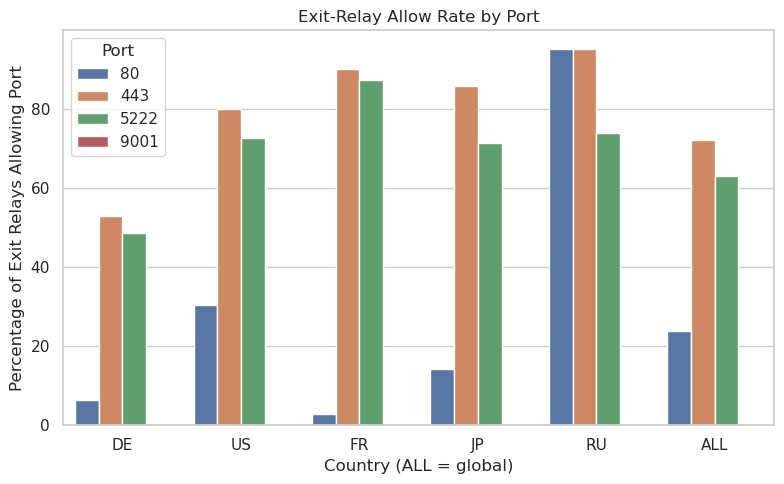

Significant TorPerf events: ['Restarted the snowflake-02 bridge for a performance enhancement. Upgraded tor from 0.4.8.6 to 0.4.8.8.', 'Restart of snowflake-01 bridge for Debian 11.8 upgrade. Upgraded tor from 0.4.8.6 to 0.4.8.7.', 'The snowflake-02 bridge suddenly recovers a large amount of bandwidth, after two weeks of low usage following the domain front change of 2023-09-20.', 'Upgraded tor from 0.4.7.13 to 0.4.8.6 on the snowflake-01 bridge. As with the upgrade on snowflake-02 on 2023-09-24, this causes the reporting of spurious OR protocol users.', 'Upgraded tor from 0.4.7.13 to 0.4.8.6 on the snowflake-02 bridge. As the result of an apparent bug, the bridge starts reporting a number of OR protocol users about equal to the number of Snowflake users.', 'The snowflake-01 bridge suddenly recovers a large amount of bandwidth, about 24 hours after the domain front change of 2023-09-20 started to lower the number of users.', 'Restarted snowflake-01 bridge for a profiling change.', 'Res

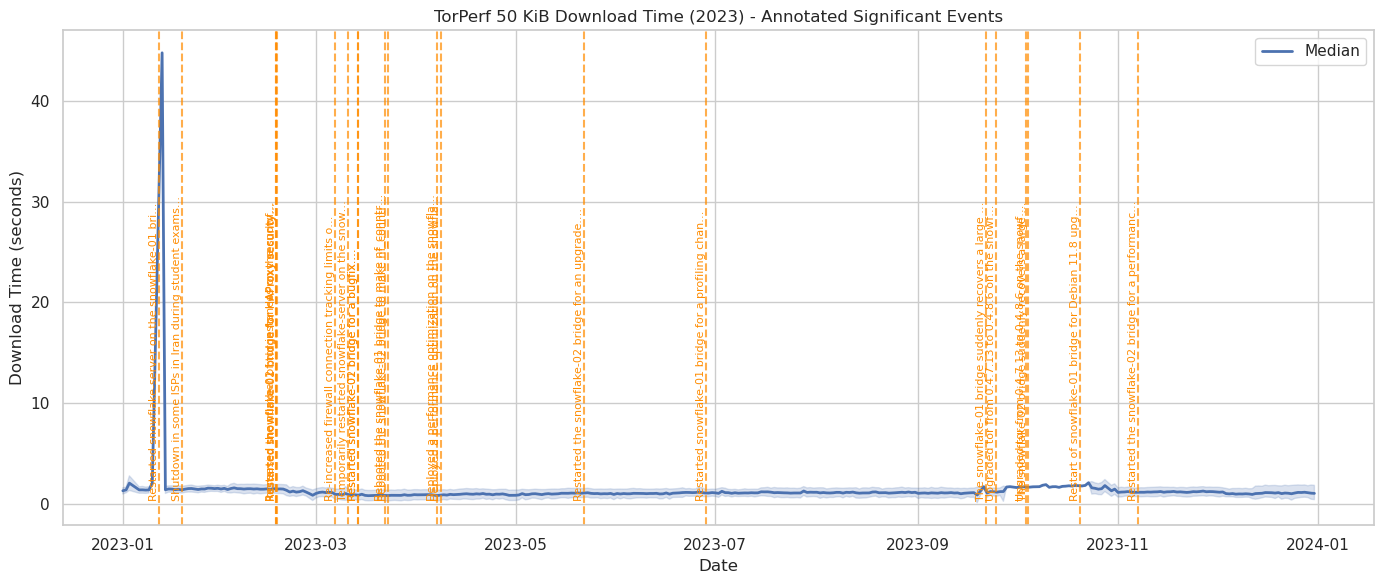

In [7]:
# 1) Define list of countries and ports
countries = ['de', 'us', 'fr', 'jp', 'ru']  # country filters
ports     = ['80', '443', '5222', '9001']   # ports to examine

records = []
for country in countries + ['all']:
    # Use the details endpoint to fetch exit_policy_summary
    if country == 'all':
        url = (
            "https://onionoo.torproject.org/details?"
            "type=relay&flag=Exit&fields=exit_policy_summary"
        )
    else:
        url = (
            f"https://onionoo.torproject.org/details?"
            f"type=relay&flag=Exit&country={country}&fields=exit_policy_summary"
        )
    resp  = requests.get(url)
    data  = resp.json().get('relays', [])
    total = len(data)
    
    for port in ports:
        # Count how many relays allow port X
        cnt = 0
        for r in data:
            policy = r.get('exit_policy_summary', {})
            accept = policy.get('accept', [])
            # each accept entry is like "80-80", "443-443" or "1000-2000"
            for prange in accept:
                start, _, end = prange.partition('-')
                if start == port:
                    cnt += 1
                    break
        records.append({
            'country': country.upper(),
            'port':    port,
            'count':   cnt,
            'total':   total,
            'percent': cnt / total * 100 if total else 0
        })

df_ports = pd.DataFrame(records)

# Display results as pivot table
print(
    df_ports
      .pivot(index='port', columns='country', values='percent')
      .round(1)
)

# 2) Barplot: percentage of exit-relays allowing each port
plt.figure(figsize=(8,5))
sns.barplot(data=df_ports, x='country', y='percent', hue='port')
plt.title('Exit-Relay Allow Rate by Port')
plt.xlabel('Country (ALL = global)')
plt.ylabel('Percentage of Exit Relays Allowing Port')
plt.legend(title='Port')
plt.tight_layout()
plt.show()


# 3) Function: filter events by change in TorPerf median
def filter_events_by_change_metric(df, events, metric='md',
                                   window_days=7, pct_threshold=0.10):
    """
    Keep events where the relative change in `metric`
    over ±window_days is at least pct_threshold.
    """
    temp = df.set_index('date').sort_index()
    relevant = []
    for _, ev in events.iterrows():
        d0   = ev['start_date']
        prev = temp[metric].asof(d0 - pd.Timedelta(days=window_days))
        nxt  = temp[metric].asof(d0 + pd.Timedelta(days=window_days))
        if pd.isna(prev) or pd.isna(nxt):
            continue
        if abs(nxt - prev) / prev >= pct_threshold:
            relevant.append(ev)
    return pd.DataFrame(relevant)

# Apply to df_perf (median download time = 'md')
events_perf = filter_events_by_change_metric(
    df_perf.assign(date=pd.to_datetime(df_perf['date'])),
    events,
    metric='md',
    window_days=7,
    pct_threshold=0.10
)
print("Significant TorPerf events:", events_perf['description'].tolist())

# 4) Plot TorPerf median with annotated significant events
plt.figure(figsize=(14,6))
sns.lineplot(data=df_perf, x='date', y='md', label='Median', linewidth=2)
plt.title('TorPerf 50 KiB Download Time (2023) - Annotated Significant Events')
plt.xlabel('Date')
plt.ylabel('Download Time (seconds)')

ymin, ymax = plt.ylim()
for _, ev in events_perf.iterrows():
    d = ev['start_date']
    plt.axvline(d, color='darkorange', linestyle='--', alpha=0.7)
    plt.text(
        d,
        ymin + (ymax - ymin) * 0.05,
        ev['description'][:50] + '…',
        rotation=90,
        va='bottom',
        ha='right',
        fontsize=8,
        color='darkorange'
    )

plt.legend()
plt.tight_layout()
plt.show()


### 3.3 Germany monthly OnionPerf analysis & 443-BW correlation

In [8]:
# Path to the local MaxMind GeoLite2 Country database
GEOIP_DB = "GeoLite2-Country.mmdb"

# Initialize the GeoIP2 reader once
geoip_reader = geoip2.database.Reader(GEOIP_DB)

def extract_bw443_share_from_consensus_text(raw_bytes, verbose=False):
    """
    Parse a consensus blob and compute the total bandwidth and
    the portion of that bandwidth from German exit relays that
    allow port 443.

    Parameters
    ----------
    raw_bytes : bytes
        Raw bytes of a single consensus file.
    verbose : bool, optional
        If True, print debug info for the first few routers.

    Returns
    -------
    tuple of (int, int)
        (total_bandwidth, germany_443_bandwidth)
    """
    total_bw   = 0
    de443_bw   = 0
    exit_count = 0

    bio = BytesIO(raw_bytes)

    for router in parse_file(
            bio,
            descriptor_type="network-status-consensus-3 1.0",
            document_handler=DocumentHandler.ENTRIES):
        # Only consider Exit relays
        if 'Exit' not in router.flags:
            continue
        exit_count += 1

        bw = router.bandwidth or 0
        total_bw += bw

        # Check if port 443 is allowed
        policy_ok = False
        if router.exit_policy:
            try:
                policy_ok = router.exit_policy.can_exit_to('0.0.0.0', 443)
            except:
                policy_ok = False

        # Determine relay IP address
        if hasattr(router, 'address'):
            ip = router.address
        elif router.or_addresses:
            ip = router.or_addresses[0][0]
        else:
            ip = None

        # Perform GeoIP lookup
        country = None
        if ip:
            try:
                resp    = geoip_reader.country(ip)
                country = resp.country.iso_code
            except Exception as e:
                if verbose:
                    print(f"    ! GeoIP lookup failed for {ip}: {e}")

        # Accumulate bandwidth if this is a German relay allowing 443
        if policy_ok and country and country.upper() == 'DE':
            de443_bw += bw

        if verbose and exit_count <= 3:
            print(f"    [{router.nickname}] bw={bw}, allows443={policy_ok}, country={country}")

    if verbose:
        print(f"    → Exit relays counted: {exit_count}, total_bw={total_bw}, de443_bw={de443_bw}")

    return total_bw, de443_bw


def parse_consensus_month(month, verbose=False):
    """
    Download a monthly consensus archive, compute the 443-bandwidth share
    for German exit relays for each hourly snapshot, and return the median.

    Parameters
    ----------
    month : str
        Month in 'YYYY-MM' format.
    verbose : bool, optional
        If True, print intermediate debug output.

    Returns
    -------
    dict
        {'month': month, 'pct_bw443': median_percentage}
    """
    url = f"https://collector.torproject.org/archive/relay-descriptors/consensuses/consensuses-{month}.tar.xz"
    print(f"[{month}] Downloading {url} …")
    resp = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    if not resp.ok:
        print(f"  ⚠️ HTTP error {resp.status_code}")
        return {"month": month, "pct_bw443": None}

    tar = tarfile.open(fileobj=BytesIO(resp.content), mode="r:xz")

    pct_list = []
    count    = 0
    for member in tar.getmembers():
        if not member.isfile() or not member.name.endswith("-consensus"):
            continue
        count += 1
        raw = tar.extractfile(member).read()
        total_bw, de443_bw = extract_bw443_share_from_consensus_text(raw, verbose=verbose)
        if total_bw > 0:
            pct = de443_bw / total_bw * 100
            pct_list.append(pct)
            if verbose:
                print(f"    Snapshot #{count}: pct={pct:.2f}%")
        elif verbose:
            print(f"    Snapshot #{count}: no traffic")

        # If verbose, only debug first 5 snapshots
        if verbose and count >= 5:
            print("    … debug limit reached …")
            break

    tar.close()
    print(f"  → Snapshots processed: {count}, valid measurements: {len(pct_list)}")

    median_pct = pd.Series(pct_list).median() if pct_list else None
    print(f"  → Month {month} median share: {median_pct}\n")
    return {"month": month, "pct_bw443": median_pct}


# Run for all months in 2023 (verbose=False for normal runs, True for debugging)
results = []
for m in range(1,13):
    mon = f"2023-{m:02d}"
    results.append(parse_consensus_month(mon, verbose=False))

df_monthly_de = pd.DataFrame(results)
df_monthly_de.to_csv("monthly_exit443_share_de.csv", index=False)
print("CSV saved: monthly_exit443_share_de.csv")


[2023-01] Downloading https://collector.torproject.org/archive/relay-descriptors/consensuses/consensuses-2023-01.tar.xz …
  → Snapshots processed: 744, valid measurements: 744
  → Month 2023-01 median share: 29.13067613362765

[2023-02] Downloading https://collector.torproject.org/archive/relay-descriptors/consensuses/consensuses-2023-02.tar.xz …
  → Snapshots processed: 672, valid measurements: 672
  → Month 2023-02 median share: 28.065767966210515

[2023-03] Downloading https://collector.torproject.org/archive/relay-descriptors/consensuses/consensuses-2023-03.tar.xz …
  → Snapshots processed: 742, valid measurements: 742
  → Month 2023-03 median share: 30.537328160778603

[2023-04] Downloading https://collector.torproject.org/archive/relay-descriptors/consensuses/consensuses-2023-04.tar.xz …
  → Snapshots processed: 716, valid measurements: 716
  → Month 2023-04 median share: 30.526298588929308

[2023-05] Downloading https://collector.torproject.org/archive/relay-descriptors/consensu

In [9]:
df_monthly_de

,month,pct_bw443
0,2023-01,29.130676
1,2023-02,28.065768
2,2023-03,30.537328
3,2023-04,30.526299
4,2023-05,29.795207
5,2023-06,28.729220
6,2023-07,24.867414
7,2023-08,27.101984
8,2023-09,29.260251
9,2023-10,28.614994


In [12]:
def parse_onionperf_month(month):
    """
    Download and parse an OnionPerf monthly archive, extracting the median
    download time for a 50 KiB file from German measurement servers.

    Parameters
    ----------
    month : str
        Month in 'YYYY-MM' format to process (e.g. '2023-01').

    Returns
    -------
    pandas.DataFrame
        DataFrame with two columns:
        - 'date': datetime of each measurement day.
        - 'time_s': median download time (seconds) for that day.
    """
    url = f"https://collector.torproject.org/archive/onionperf/onionperf-{month}.tar.xz"
    resp = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    tar = tarfile.open(fileobj=BytesIO(resp.content), mode="r:xz")
    recs = []
    for member in tar.getmembers():
        if not member.name.endswith(".analysis.json.xz"):
            continue
        fn = member.name.split("/")[-1]
        if ".op-de" not in fn:
            continue
        date_str = fn.split(".")[0]
        source   = fn.split(".")[1]
        f = tar.extractfile(member)
        raw = f.read()
        try:
            data = json.loads(lzma.decompress(raw))
        except Exception:
            continue

        streams = data.get("data", {}).get(source, {}).get("tgen", {}).get("streams", {})
        for s_id, s_data in streams.items():
            try:
                t = s_data["elapsed_seconds"]["payload_bytes_recv"]["5242880"]
                recs.append({"date": date_str, "time_s": float(t)})
            except (KeyError, TypeError):
                continue

    tar.close()
    if not recs:
        return pd.DataFrame(columns=["date", "time_s"])
    df = pd.DataFrame(recs)
    df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d", errors="coerce")
    return df.dropna(subset=["date"])

# 1) Process all months in 2023
dfs = []
for i, month in enumerate([f"2023-{m:02d}" for m in range(1, 13)], start=1):
    print(f"[{i}/12] Processing month: {month}")
    try:
        df = parse_onionperf_month(month)
        print(f"  → Found {len(df)} records")
        dfs.append(df)
    except Exception as e:
        print(f"  ⚠️ Error processing {month}: {e}")
df_onion_de = pd.concat(dfs, ignore_index=True)

# Ensure 'date' column exists and is datetime
if "date" not in df_onion_de.columns:
    raise RuntimeError("Column 'date' is missing – invalid input from parse_onionperf_month")

# Convert to datetime if not already
df_onion_de["date"] = pd.to_datetime(df_onion_de["date"], errors="coerce")

# Drop invalid or missing dates
df_onion_de = df_onion_de.dropna(subset=["date"])

# Set index to date
df_onion_de.set_index("date", inplace=True)

# Ensure the index is a DatetimeIndex (required for resampling)
if not isinstance(df_onion_de.index, pd.DatetimeIndex):
    raise TypeError("Index is not a DatetimeIndex – cannot resample")

# Resample safely to compute monthly median
monthly_onion = (
    df_onion_de["time_s"]
    .resample("M")
    .median()
    .reset_index()
    .rename(columns={"time_s": "onionperf_median", "date": "month"})
)

monthly_onion.to_csv("monthly_onionperf_de.csv", index=False)


[1/12] Processing month: 2023-01
  → Found 109956 records
[2/12] Processing month: 2023-02
  → Found 107874 records
[3/12] Processing month: 2023-03
  → Found 151907 records
[4/12] Processing month: 2023-04
  → Found 154828 records
[5/12] Processing month: 2023-05
  → Found 155869 records
[6/12] Processing month: 2023-06
  → Found 148135 records
[7/12] Processing month: 2023-07
  → Found 112151 records
[8/12] Processing month: 2023-08
  → Found 71263 records
[9/12] Processing month: 2023-09
  → Found 74305 records
[10/12] Processing month: 2023-10
  → Found 57952 records
[11/12] Processing month: 2023-11
  → Found 94659 records
[12/12] Processing month: 2023-12
  → Found 99946 records


/tmp/ipykernel_23669/1326740277.py:84: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")


CSVs exported: 'monthly_onionperf_de.csv' & 'onionperf_bw_correlation_de.csv'


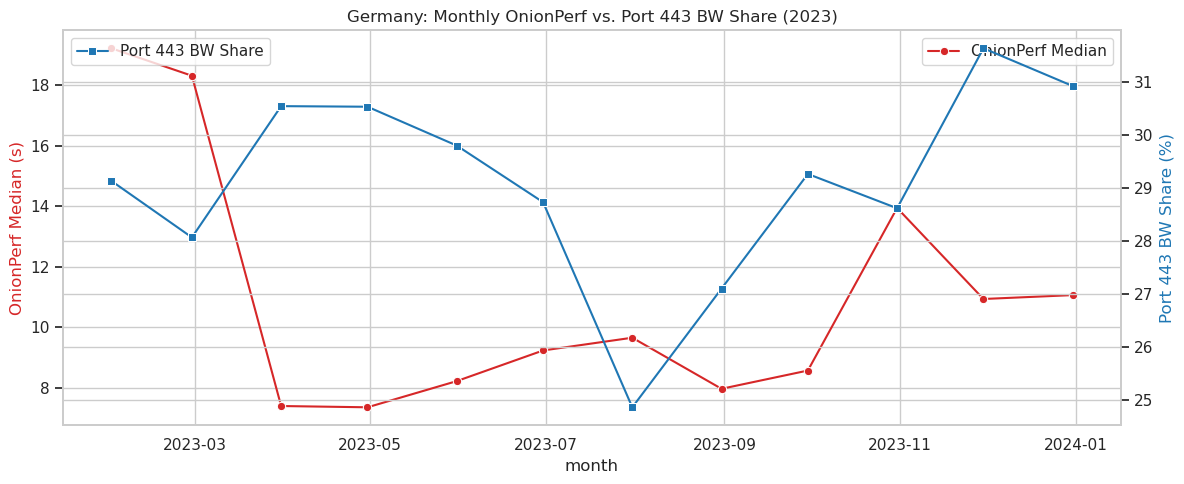

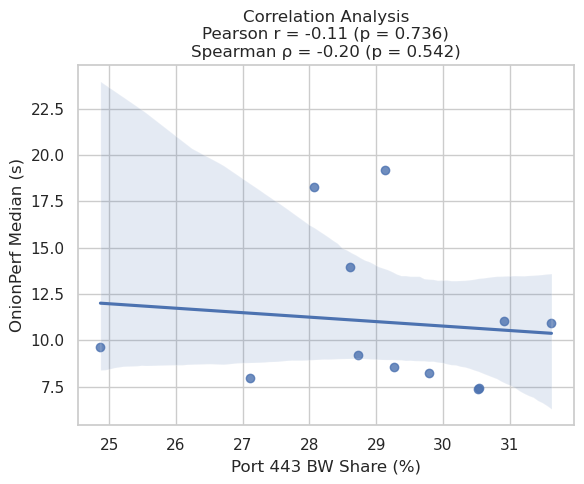

Pearson r = -0.11, p-value = 0.736
Spearman ρ = -0.20, p-value = 0.542


In [13]:
# Load precomputed monthly OnionPerf medians and exit-BW shares
monthly_onion = pd.read_csv("monthly_onionperf_de.csv", parse_dates=["month"])
df_monthly_de = pd.read_csv("monthly_exit443_share_de.csv")  # month in 'YYYY-MM' format

# Convert df_monthly_de.month ("2023-01") to end-of-month datetime
df_monthly_de['month'] = (
    pd.to_datetime(df_monthly_de['month'], format='%Y-%m')
      + MonthEnd(1)
)

# Merge the two DataFrames on the 'month' column
merged = pd.merge(
    monthly_onion,
    df_monthly_de[['month', 'pct_bw443']],
    on='month',
    how='inner'
)

# Save the merged results
merged.to_csv("onionperf_bw_correlation_de.csv", index=False)
print("CSVs exported: 'monthly_onionperf_de.csv' & 'onionperf_bw_correlation_de.csv'")

# 1) Time series plot of OnionPerf and 443-BW share
plt.figure(figsize=(12, 5))
ax1 = plt.gca()
sns.lineplot(
    data=merged, x="month", y="onionperf_median",
    marker="o", label="OnionPerf Median", ax=ax1, color="tab:red"
)
ax2 = ax1.twinx()
sns.lineplot(
    data=merged, x="month", y="pct_bw443",
    marker="s", label="Port 443 BW Share", ax=ax2, color="tab:blue"
)
ax1.set_ylabel("OnionPerf Median (s)", color="tab:red")
ax2.set_ylabel("Port 443 BW Share (%)", color="tab:blue")
ax1.set_title("Germany: Monthly OnionPerf vs. Port 443 BW Share (2023)")
plt.tight_layout()
plt.show()

# 2) Pearson and Spearman correlation analysis
pearson_r, pearson_p   = pearsonr(merged["pct_bw443"], merged["onionperf_median"])
spearman_r, spearman_p = spearmanr(merged["pct_bw443"], merged["onionperf_median"])

# Scatter plot with linear regression line
plt.figure(figsize=(6, 5))
sns.regplot(
    data=merged,
    x="pct_bw443",
    y="onionperf_median",
    marker="o"
)
plt.title(
    f"Correlation Analysis\n"
    f"Pearson r = {pearson_r:.2f} (p = {pearson_p:.3f})\n"
    f"Spearman ρ = {spearman_r:.2f} (p = {spearman_p:.3f})"
)
plt.xlabel("Port 443 BW Share (%)")
plt.ylabel("OnionPerf Median (s)")
plt.tight_layout()
plt.show()

print(f"Pearson r = {pearson_r:.2f}, p-value = {pearson_p:.3f}")
print(f"Spearman ρ = {spearman_r:.2f}, p-value = {spearman_p:.3f}")


In [ ]:
geoip_reader.close()


### 3.4 monthly OnionPerf analysis & BW correlation for different countries and ports

*which i didn't execute in time, but i wanted to show the possibility*

In [ ]:
# Countries and ports to analyze
countries     = ['de', 'us', 'fr', 'jp', 'ru', 'all']
ports         = ['80', '443', '5222']

# GeoIP2 reader (requires GeoLite2-Country.mmdb in working directory)
GEOIP_DB      = "GeoLite2-Country.mmdb"
geoip_reader  = geoip2.database.Reader(GEOIP_DB)

def extract_bw_share(raw_bytes, port, country_code=None):
    """
    Parse a consensus snapshot and compute:
      - bw_total: total exit bandwidth
      - bw_port:  exit bandwidth that allows `port` by relays in `country_code`
    
    raw_bytes   : raw bytes of a consensus descriptor
    port        : string port number to check (e.g. '443')
    country_code: two-letter lower-case country code (e.g. 'de'), or None for global
    
    Returns
    -------
    (bw_total, bw_port)
    """
    bw_total = 0
    bw_port  = 0
    bio = BytesIO(raw_bytes)

    for router in parse_file(
            bio,
            descriptor_type="network-status-consensus-3 1.0",
            document_handler=DocumentHandler.ENTRIES):
        # only consider exit relays
        if 'Exit' not in router.flags:
            continue

        bw = router.bandwidth or 0
        bw_total += bw

        # check if exit policy allows the specified port
        if router.exit_policy and router.exit_policy.can_exit_to('0.0.0.0', int(port)):
            if country_code is None:
                # global count
                bw_port += bw
            else:
                # GeoIP lookup for country-specific count
                ip = getattr(router, 'address', None) or (
                     router.or_addresses and router.or_addresses[0][0]
                )
                if ip:
                    try:
                        cc = geoip_reader.country(ip).country.iso_code.lower()
                    except:
                        cc = None
                    if cc == country_code:
                        bw_port += bw

    return bw_total, bw_port


def parse_exit_shares(month):
    """
    Download and parse all hourly consensus snapshots for a given month,
    computing the median percentage of exit bandwidth on each port, 
    for each country in `countries`.

    month : str
        Month in 'YYYY-MM' format (e.g. '2023-01').

    Returns
    -------
    list of dicts
        Each dict has keys: 'country', 'port', 'month', 'pct_bw'.
    """
    url = f"https://collector.torproject.org/archive/relay-descriptors/consensuses/consensuses-{month}.tar.xz"
    resp = requests.get(url)
    resp.raise_for_status()
    tar = tarfile.open(fileobj=BytesIO(resp.content), mode="r:xz")

    records = []
    for code in countries:
        # interpret 'all' as global (country_code=None)
        cc_arg = None if code == 'all' else code
        for port in ports:
            pct_list = []
            for member in tar.getmembers():
                if not member.isfile() or not member.name.endswith("-consensus"):
                    continue
                raw = tar.extractfile(member).read()
                total_bw, port_bw = extract_bw_share(raw, port, country_code=cc_arg)
                if total_bw > 0:
                    pct_list.append(port_bw / total_bw * 100)
            median_pct = pd.Series(pct_list).median() if pct_list else None
            records.append({
                'country': code.upper(),
                'port':    port,
                'month':   month,
                'pct_bw':  median_pct
            })

    tar.close()
    return records


# Process all months in 2023 and save results
all_records = []
for m in [f"2023-{i:02d}" for i in range(1, 13)]:
    print(f"Processing {m} …")
    all_records += parse_exit_shares(m)

df_exit = pd.DataFrame(all_records)
df_exit.to_csv("monthly_exit443_share_by_country.csv", index=False)
print("Saved CSV: monthly_exit443_share_by_country.csv")


Verarbeite 2023-01


KeyboardInterrupt: 

In [ ]:
# Country prefixes for OnionPerf filenames
country_prefix = {
    'DE': 'op-de', 'US': 'op-us', 'FR': 'op-fr',
    'JP': 'op-jp', 'RU': 'op-ru'
}

def parse_onionperf_month(month):
    """
    Download the monthly OnionPerf archive and extract median download times
    for each measurement site, grouping by country code (DE, US, FR, JP, RU, or ALL).

    Parameters
    ----------
    month : str
        Month in 'YYYY-MM' format (e.g. '2023-01').

    Returns
    -------
    pandas.DataFrame
        Columns:
          - country       : two-letter country code (or 'ALL')
          - date          : timestamp of each measurement day
          - time_s        : median download time (seconds) for 5 MiB via Tor
    """
    url = f"https://collector.torproject.org/archive/onionperf/onionperf-{month}.tar.xz"
    resp = requests.get(url)
    resp.raise_for_status()
    tar = tarfile.open(fileobj=BytesIO(resp.content), mode="r:xz")

    rows = []
    for member in tar.getmembers():
        if not member.name.endswith(".analysis.json.xz"):
            continue

        filename = member.name.split("/")[-1]
        date_str, src = filename.split(".", 2)[0], filename.split(".")[1]

        raw = tar.extractfile(member).read()
        data = json.loads(lzma.decompress(raw))
        streams = data["data"][src]["tgen"]["streams"]

        # collect all 5 MiB download times for this day and site
        times = [
            float(s["elapsed_seconds"]["payload_bytes_recv"].get("5242880"))
            for s in streams.values()
            if s["elapsed_seconds"]["payload_bytes_recv"].get("5242880")
        ]
        if not times:
            continue

        # determine country code based on filename prefix
        for cc, pref in country_prefix.items():
            if src.startswith(pref):
                country = cc
                break
        else:
            country = 'ALL'

        rows.append({
            'country': country,
            'date':    pd.to_datetime(date_str),
            'time_s':  pd.Series(times).median()
        })

    tar.close()
    return pd.DataFrame(rows)


# 1) Parse all months in 2023
dfs = []
for m in [f"2023-{i:02d}" for i in range(1, 13)]:
    print(f"Parsing OnionPerf data for {m} …")
    dfs.append(parse_onionperf_month(m))
df_perf_all = pd.concat(dfs, ignore_index=True)

# 2) Resample monthly medians per country (including 'ALL')
out = []
for cc in df_perf_all['country'].unique():
    tmp = df_perf_all[df_perf_all['country'] == cc].set_index('date')
    monthly = (
        tmp['time_s']
        .resample('M')
        .median()
        .reset_index()
        .rename(columns={'time_s': 'md_performance', 'date': 'month'})
    )
    monthly['country'] = cc
    out.append(monthly)

df_perf = pd.concat(out, ignore_index=True)

# 3) Save to CSV
df_perf.to_csv("monthly_performance_by_country.csv", index=False)
print("Saved CSV: monthly_performance_by_country.csv")


### 4. Interpretation and Reporting

This section discusses the findings from our analysis of the Tor network, focusing on the comparison between Germany and global trends. We will relate these findings to Tor's core goals, acknowledge the limitations of our data and methodology, and suggest avenues for future research.

#### 4.1. Discussion of Findings

Our research question aimed to uncover differences in Tor exit traffic patterns and network performance between Germany and the global network. The analysis yielded several key insights into usage, performance, and their interrelation.

##### Exit Policy: A Homogeneous Landscape for Web Traffic

The initial analysis of exit relay policies provides a foundational understanding of what kind of traffic the Tor network facilitates. At the time of data collection, **Germany played a substantial role in the Tor exit network**, contributing **303 exit relays out of a global total of 2,754**. This makes Germany one of the most significant contributors of exit capacity.

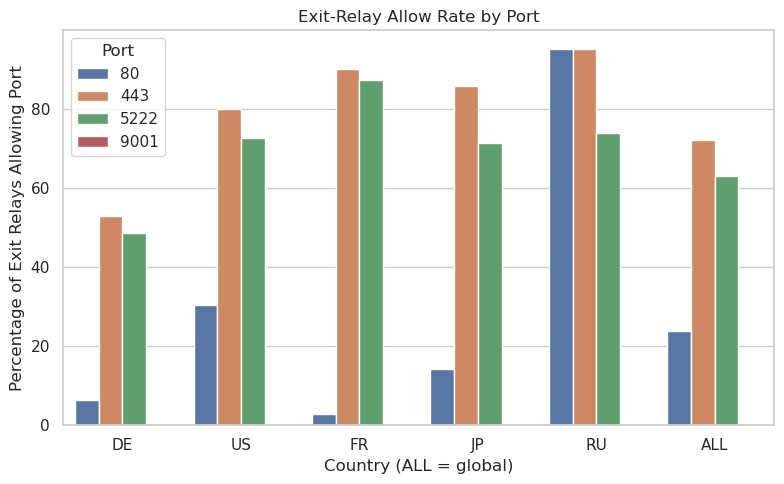

The bar chart above illustrates the percentage of exit relays permitting traffic on selected ports. A key finding is the dominance of **Port 443 (HTTPS)** and **Port 80 (HTTP)** across all analyzed regions. This is expected, as they are the standard ports for web browsing, which constitutes the majority of internet traffic. Out of Germany's 303 exits, **160 had a policy allowing Port 443 traffic**, compared to a total of 1,985 globally.

Crucially, **Germany's exit policy profile is remarkably similar to the global average.** There is no significant deviation that would suggest German users utilize Tor for a niche purpose not seen elsewhere. This homogeneity is beneficial for **anonymity**. When a user's traffic (e.g., browsing HTTPS websites) from a specific country blends in with the traffic from the larger pool of global users, it becomes more difficult for an adversary to single out or profile them based on their country of origin. This "blending in" effect is a cornerstone of Tor's design.

An interesting outlier in the chart is **Russia (RU)**, where the allow-rate for Port 80 (HTTP) is almost identical to that for Port 443 (HTTPS). This contrasts with other countries where Port 443 is more frequently permitted. There are several potential hypotheses for this observation:
1.  **Operator Philosophy:** Relay operators in Russia may hold a stronger belief in providing access to the *entire* internet, including legacy unencrypted sites, thus being more permissive with their Port 80 policies.
2.  **Specific Use Cases:** It's possible that specific websites or services popular among Russian-speaking users, or certain censorship circumvention tools, still rely on HTTP.
3.  **Network-Level Filtering:** In some regions, ISPs or state-level firewalls might be more aggressive in throttling or blocking standard HTTPS traffic, inadvertently making Port 80 a more reliable, albeit less secure, channel for some applications.

Without further investigation, this remains speculative, but it highlights a regional variation worthy of future study.

##### Network Dynamics: Users and Performance in 2023

To understand the network's operational reality, we examined time-series data for user numbers and download performance, annotating them with relevant events from the Tor Project's timeline.

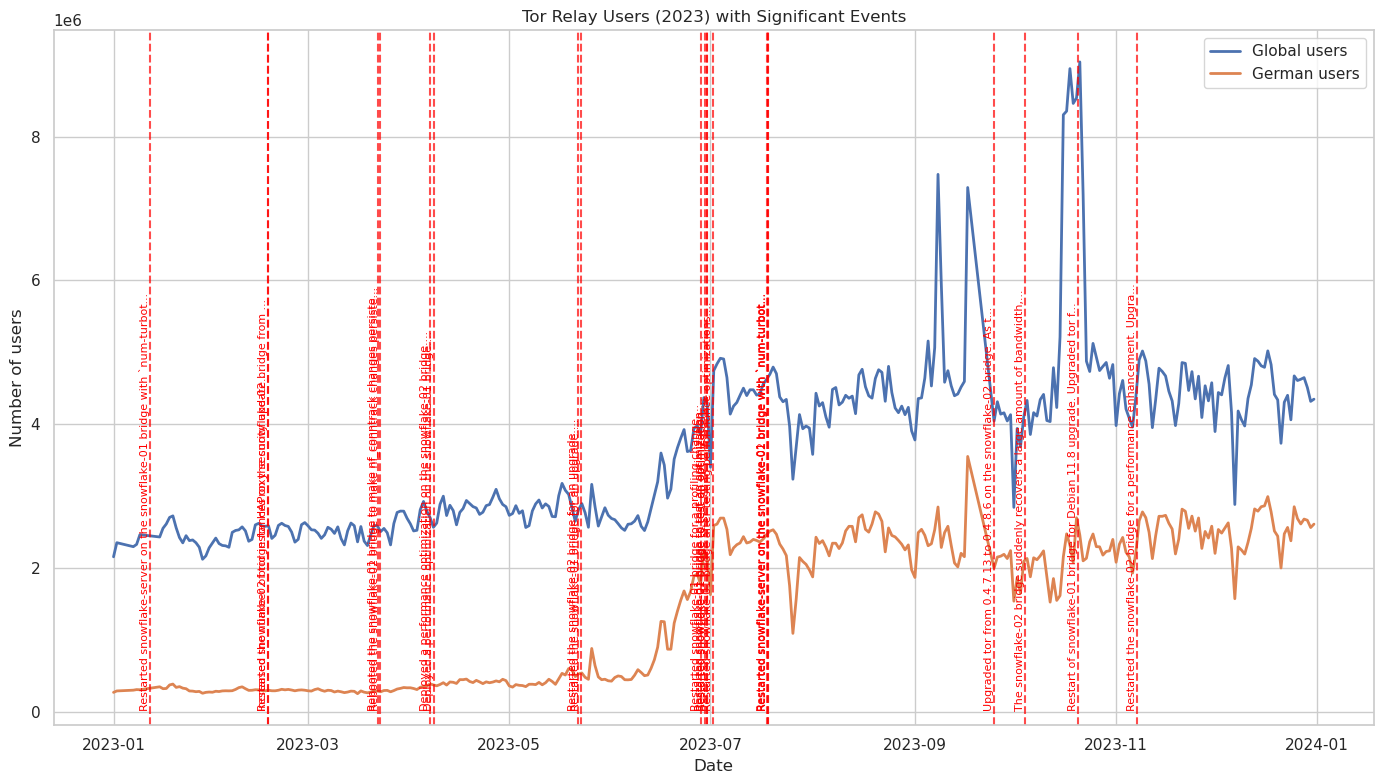

The user graph shows fluctuations in both global and German user numbers throughout 2023. While we filtered for events that coincided with significant changes in user counts, a direct and consistent causal link is not immediately apparent from the visualization alone. Network user numbers are influenced by a complex mix of factors, including global events, censorship efforts in various countries, and the availability of circumvention tools. The chart illustrates the inherent volatility and complexity of the network ecosystem.

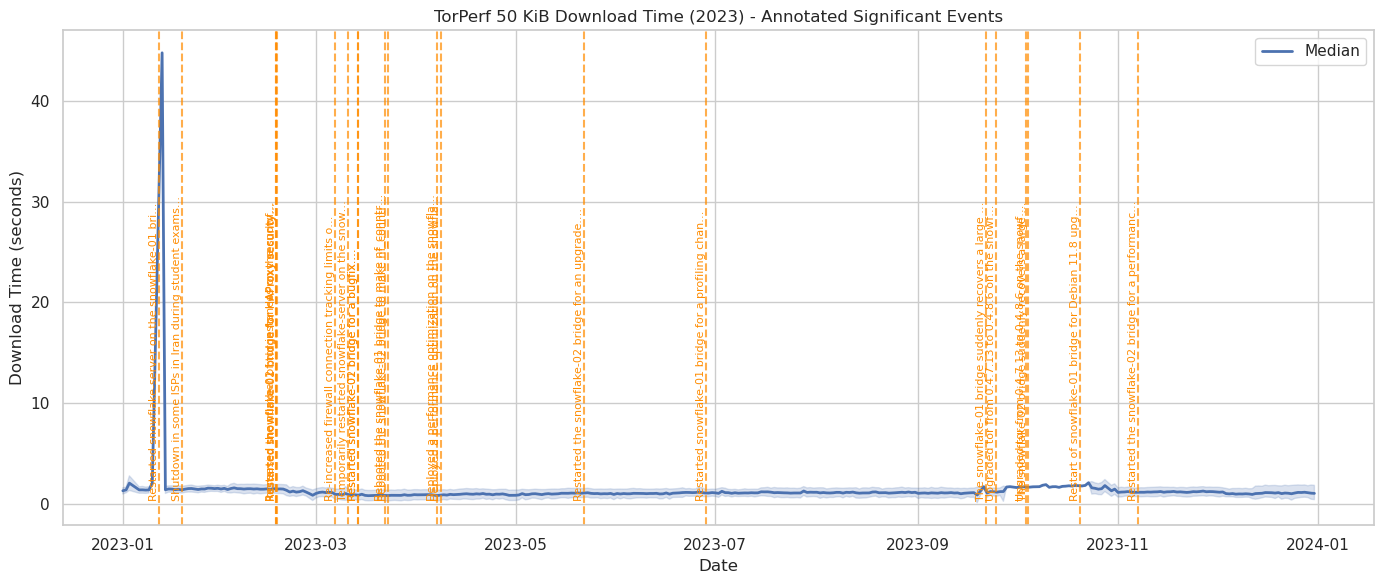

The TorPerf download time chart offers a view into network performance. We can observe a significant performance degradation (a spike in download times) in early 2023, followed by a period of stabilization. The annotations, which are based on an "incomplete" timeline of events, provide potential explanations. For example, events like the restart of a major snowflake bridge or performance optimizations can have a measurable, albeit sometimes temporary, impact on performance metrics. This highlights how the performance experienced by users is directly tied to the operational status and maintenance of the network's infrastructure.

##### The (Non-Existent) Correlation Between Port 443 Bandwidth and Performance in Germany

The core of our specific investigation was to determine if a relationship exists between the availability of Port 443-allowing exit bandwidth in Germany and the measured download performance for German users.

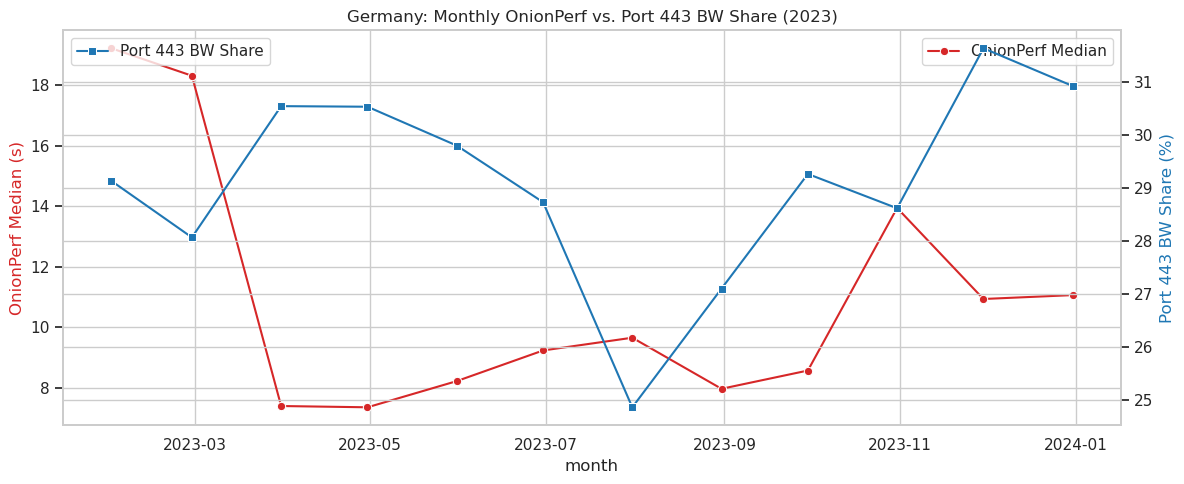

The dual-axis line chart plots the median monthly OnionPerf download time against the percentage of total network bandwidth contributed by German exit relays that allow Port 443. Visually, there is no clear pattern. At times, performance improves (lower download time) as the 443-bandwidth share decreases, and vice-versa. This suggests that the two metrics are not strongly related.

To confirm this observation statistically, we performed a correlation analysis.

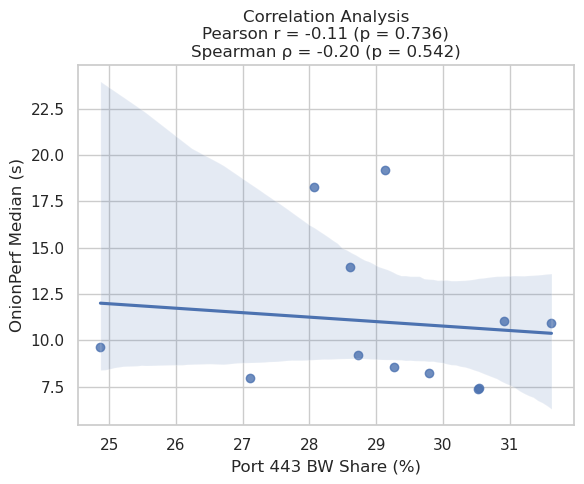

The scatter plot and the resulting correlation coefficients confirm our visual assessment. We found:
- **Pearson r = -0.11 (p=0.736)**
- **Spearman ρ = -0.20 (p=0.542)**

Both coefficients indicate a very weak negative correlation. More importantly, the **p-values are extremely high** (p >> 0.05). This means the observed weak relationship is **not statistically significant** and is very likely the result of random chance.

**Conclusion:** Our analysis found no evidence to support the hypothesis that a higher share of German exit bandwidth allowing Port 443 leads to better (i.e., faster) download performance for German-based measurements. Tor network performance is a multi-faceted issue, likely influenced far more by factors such as the total available network bandwidth, the performance of middle relays, overall network congestion, and the specific path chosen for a circuit, rather than the bandwidth share of one country for a single port.

#### 4.2. Reflect on the limitations of the data

Our analysis, while insightful, is subject to several limitations:

1.  **Scope Limited to Germany and Port 443:** Due to time constraints, the detailed correlation analysis was confined to Germany and the most common port, 443. The original research question was broader. The scripts to perform this analysis for other countries (e.g., US, FR, RU) and other key ports were developed (as shown in notebook section 3.4), but the data was not collected and analyzed. This means our conclusions are specific to the German context and cannot be generalized.
2.  **GeoIP Accuracy:** The GeoLite2 database used for mapping relay IP addresses to countries is not perfect. As noted during the analysis, some IPs could not be mapped. This means our calculation of the German bandwidth share (`bw_de_443`) is an **underestimate**. The true value is likely higher.
3.  **Representativeness of OnionPerf:** The OnionPerf data was sourced from `.op-de` files, representing measurements from a specific vantage point in Germany. This does not capture the full spectrum of experiences for all German Tor users.
4.  **Monthly Aggregation:** By aggregating data into monthly medians, we smooth out short-term fluctuations. A more granular analysis might reveal relationships that are missed on a monthly scale.
5.  **Incomplete Event Data:** The event timeline provided by the Tor Project is explicitly "incomplete." Major performance or user fluctuations could be caused by unlisted events, making definitive causal attribution difficult.
6.  **Correlation vs. Causation:** Even if a strong correlation had been found, it would not prove causation due to the many uncontrolled confounding variables in the live Tor network.

#### 4.3. Suggest improvements or further research directions

Based on our findings and their limitations, several avenues for future research emerge:

1.  **Expand the Scope:** The most direct next step is to **execute the analysis for which the scripts have already been prepared** (in section 3.4). Applying the same methodology to other countries and ports would allow for a robust cross-country comparison. This would help determine if the non-correlation observed in Germany is a global phenomenon or a local characteristic.
2.  **Investigate the Russian Anomaly:** The high allow-rate for Port 80 in Russia warrants a dedicated investigation. This could involve analyzing historical exit policies to see if this is a recent trend and correlating it with regional internet censorship events.
3.  **Improve GeoIP Mapping:** Future work could explore using multiple commercial and open-source GeoIP databases to create a more robust mapping consensus, reducing the number of un-located relays and improving the accuracy of country-specific metrics.
4.  **Incorporate More Variables:** A more sophisticated statistical model (e.g., multiple regression) could be built to predict performance. This model could include not just exit bandwidth, but also variables like total network bandwidth, the number of middle relays, and the Gini coefficient of bandwidth distribution (to measure decentralization).
5.  **Analyze Pluggable Transports:** A dedicated study on the usage and performance of PTs like Snowflake and obfs4, particularly in regions with active censorship, would be highly valuable, linking PT availability to user numbers from specific countries.

### 5. References
[0] https://www.torproject.org
[1] https://metrics.torproject.org
[2] https://metrics.torproject.org/sources.html
[3] https://metrics.torproject.org/torperf.html
[4] https://data.niaid.nih.gov/resources?id=zenodo_10620519
[5] https://murdoch.is/papers/wecsr10measuring.pdf
[6] https://stem.torproject.org/
[7] https://www.rwails.org/research/jansen_gtt_arxiv24.pdf
[8] https://dl.acm.org/doi/10.1145/2976749.2978310